In [1]:
from operator import itemgetter

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import numpy as np
import torchvision

import torch.nn.functional as F
import torch.nn as nn
import torch
import torch.optim as optim

import math
from torch.nn import init
from torch.autograd import Variable
from tqdm import trange
from torch.distributions.categorical import Categorical

import scipy
import scipy.linalg
from collections import Counter
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml
from ggplot import *


#from model import CnnActorCriticNetwork, RNDModel
from utils import global_grad_norm_
device = 'cuda'


/home/aasadulaev/soft/conda2/envs/jpoenv/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,


### Dynamical Isomentry Check

In [3]:
def noise_sample(obs_batch):
    obs_batch = obs_batch.cpu().detach().numpy()
    sample = np.random.normal(size=obs_batch.shape)
    sample = torch.from_numpy(sample).float().cuda()# use .to(self.device) soon 
    return sample

def noise_sample_step(obs_batch, epsilon=1):
    obs_batch = obs_batch.cpu().detach().numpy()
    step = np.random.normal(size=obs_batch.shape)
    step = (step / np.linalg.norm(step)) * epsilon
    z_obs_batch = obs_batch + step
    z_obs_batch = torch.from_numpy(z_obs_batch).float().cuda()# use .to(self.device) soon 
    return z_obs_batch

In [4]:
def init_weights(m):
    if type(m)==nn.Linear:
        init.orthogonal_(m.weight)

In [5]:
lnn = nn.Sequential(nn.Linear(784, 784), nn.Sigmoid(), nn.Linear(784, 784))

In [6]:
lnn.apply(init_weights)

Sequential(
  (0): Linear(in_features=784, out_features=784, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=784, out_features=784, bias=True)
)

In [7]:
w = lnn[2].weight.detach().cpu().numpy()
u,s,v = scipy.linalg.svd(w)
print(np.mean(s))

1.0000001


###  Plan 
#### Train model on 10 samples from class 0 - Done
#### Create Model with separated predictors - Done
#### Train/Test Model with separated predictors - Done
#### Debug Model with separated predictors - In progress

In [2]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data/MNIST/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=1, shuffle=False)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data/MNIST/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=1, shuffle=False)

In [48]:
class RNDModel(nn.Module):
    def __init__(self, n_classes, dim=784):
        super(RNDModel, self).__init__()

        self.activated_predictor = None
        self.last_activated_predictor = None
        self.target = nn.Sequential(nn.Linear(dim, dim))
        self.predictors = {}
        self.optimizers = {}

        for c in range(n_classes):
            self.predictors[f'{c}'] = nn.Sequential(
                nn.Linear(dim, dim)
            )
            self.optimizers[f'{c}'] = \
            optim.Adam(self.predictors[f'{c}'].parameters(),
                       0.0001)
            
        #for p in self.modules():
         #   if isinstance(p, nn.Linear):
          #      init.orthogonal_(p.weight)

        #make same intialization for every predictor
        #for n, predictor in self.predictors.items():
         #   predictor.load_state_dict(self.target.state_dict())
            #print('predictor N',n, predictor[0].weight.detach().cpu().numpy())
        
        for param in self.target.parameters():
            param.requires_grad = False
                
        #for c in range(n_classes):        
         #   self.optimizers[f'{c}'] = \
          #  optim.Adam(self.predictors[f'{c}'].parameters(),
           #            0.01)
        
        
            
    def cuda_predictors(self):
        for predictor in self.predictors:
            self.predictors[predictor].cuda()
                
                
    def activate_predictor(self, class_):
        self.activated_predictor = self.predictors[f'{class_}']

        
    def get_optimizer(self, class_i):
        return self.optimizers[f"{class_i}"]
                
        
    def last_activate_predictor(self, class_):
        self.last_activated_predictor = self.predictors[f'{class_}']
            
            
    def predict(self, next_obs):
        predict_features = []
        duplets_predicts = []
        for predictor in self.predictors:
            if int(predictor) == 0:
                target_feature = self.target(next_obs)
                next_layer_features = self.predictors[predictor](next_obs) 
                duplets_predicts.append([target_feature, next_layer_features])   
            else:
                target_feature = self.predictors[str(int(predictor)-1)](next_obs)
                next_layer_features = self.predictors[predictor](next_obs)
                duplets_predicts.append([target_feature, next_layer_features])  
        
        return duplets_predicts, predict_features, target_feature
    
                                    
    def forward(self, use_target, next_obs):
        if use_target:
            target_feature = self.target(next_obs)
        else:
            target_feature = self.last_activated_predictor(next_obs)
        predict_feature = self.activated_predictor(next_obs)

        return predict_feature, target_feature
    
    def to(self, device):
        super(RNDModel, self).to(device)
        # Move all predictor networks to the same device
        if torch.cuda.is_available():
            for predictor in self.predictors:
                self.predictors[predictor].to(device)

In [66]:
rnd = RNDModel(10)
rnd.to(device)
print(rnd)

params =[]
for _, predictor in rnd.predictors.items():
    params += list(predictor.parameters())

forward_mse = nn.MSELoss(reduction='none')


def train(epoch, rnd, batch_idx, data, y, shots_num, use_target=None):
    data = data.view(data.shape[0],-1 ).to(device)
    y = y.to(device)
    if use_target==False:
        rnd.last_activate_predictor(y.cpu().numpy()[0]-1)
    rnd.activate_predictor(class_=y.cpu().numpy()[0])
    
    #w = rnd.activated_predictor[0].weight.detach().cpu().numpy()
    #u,s,v = scipy.linalg.svd(w)
    #print(np.mean(s))
    
    predict_next_state_feature, target_next_state_feature = rnd(use_target, Variable(data.to(device)))
    forward_loss = forward_mse(predict_next_state_feature, target_next_state_feature).mean()

    optimizer = rnd.get_optimizer(y.cpu().numpy()[0])
    optimizer.zero_grad()
    loss = forward_loss
    loss.backward()
    optimizer.step()

        
        
def test(rnd, test_loader, shots_num=1000):
    rnd.eval()
    test_loss = 0
    correct = 0
    mses = []
    with torch.no_grad():
        for batch_idx, (data, y)  in enumerate(test_loader): 
            data = data.view(data.shape[0],-1 )
            duplets_predicts, predict_next_state_feature, target_next_state_feature = rnd.predict(Variable(data.to(device)))

            for duplete in duplets_predicts:
                mses.append((duplete[0] - duplete[1]).pow(2).sum(1) / 2)
            min_mse = np.argmin(mses)
            #print(min_mse)
            if min_mse==y.cpu().numpy()[0]:
                correct+=1
            mses = []
        print('Accuracy: {}/{} ({:.0f}%)\n'.format(correct, batch_idx+1, 100. * correct / (batch_idx+1)))

RNDModel(
  (target): Sequential(
    (0): Linear(in_features=784, out_features=784, bias=True)
  )
)


### Full MNIST
#### Separate for dupletes layers - Done
#### Separate mnist for classes for cirruculum learning 
#### Make predict function that compare by duplets
#### Train not for duplets for subnetworks

In [5]:
def get_few_shot_mnist(data_loader, shot=10):
    few_shot_dataset = []
    class_counter = Counter()
    for batch_i, (x, y) in enumerate(data_loader):
        if class_counter[y.item()] < shot:
            class_counter[y.item()] += 1
            few_shot_dataset.append((x, y))
        if all([x == shot for x in class_counter.values()]):
            break
    return few_shot_dataset

In [53]:
few_shot_dataset = get_few_shot_mnist(train_loader, shot=2)

In [54]:
few_shot_dataset_sorted = sorted(few_shot_dataset, key=itemgetter(1), reverse =False)

In [55]:
n=2
final_few_shot_dataset_sorted = [few_shot_dataset_sorted[i * n:(i + 1) * n] for i in range((len(few_shot_dataset_sorted) + n - 1) // n )]  

In [68]:
test(rnd, test_loader)

Accuracy: 5494/10000 (55%)



In [67]:
#for epoch in range(10):
for class_ in final_few_shot_dataset_sorted:
    for epoch in range(30):
        for batch_idx, (data, y) in enumerate(class_):
            if y==0:
                use_target = True
            else:
                use_target = False
            train(epoch, rnd, batch_idx, data, y, len(few_shot_dataset),  use_target)

### PCA, TSNE

In [227]:
def tsne_plot(x, y, n_sne = 60000):
    feat_cols = [ 'pixel'+str(i) for i in range(x.shape[1]) ]
    df = pd.DataFrame(x,columns=feat_cols)
    df['label'] = y
    df['label'] = df['label'].apply(lambda i: str(i))

    print ('Size of the dataframe:', df.shape)
    rndperm = np.random.permutation(df.shape[0])
    time_start = time.time()
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(df.loc[rndperm[:n_sne],feat_cols].values)

    df_tsne = df.loc[rndperm[:n_sne],:].copy()
    df_tsne['x-tsne'] = tsne_results[:,0]
    df_tsne['y-tsne'] = tsne_results[:,1]

    chart = ggplot( df_tsne, aes(x='x-tsne', y='y-tsne', color='label') ) \
            + geom_point(size=10,alpha=0.8) \
            + ggtitle("tSNE dimensions colored by digit")

    return chart

In [204]:
def pca_plot(x, y):
    feat_cols = [ 'pixel'+str(i) for i in range(x.shape[1]) ]
    df = pd.DataFrame(x,columns=feat_cols)
    df['label'] = y
    df['label'] = df['label'].apply(lambda i: str(i))

    print ('Size of the dataframe:', df.shape)
    rndperm = np.random.permutation(df.shape[0])
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(df[feat_cols].values)

    df['pca-one'] = pca_result[:,0]
    df['pca-two'] = pca_result[:,1] 
    df['pca-three'] = pca_result[:,2]
    chart = ggplot( df.loc[rndperm[:60000],:], aes(x='pca-one', y='pca-two', color='label') ) \
        + geom_point(size=3,alpha=0.8) \
        + ggtitle("First and Second Principal Components colored by digit")

    return chart

In [70]:
mnist = fetch_openml('mnist_784')
X = mnist.data / 255.0
y = mnist.target

In [232]:
DIDX = []
DIDY = []
for batch_idx, (data, y) in enumerate(train_loader):
    data = data.view(data.shape[0],-1 )
    rnd.activate_predictor(class_=y.cpu().numpy()[0])

    _, target_next_state_feature = rnd(Variable(data.to(device)))
    DIDX.append(target_next_state_feature.cpu().numpy()[0])
    DIDY.append(y.cpu().numpy()[0])
DIDXAR = np.asarray(DIDX)
DIDYAR = np.asarray(DIDY)

In [205]:
#Non isimetry 784-out 1 layer linear network
chart_1 = pca_plot(DIDXAR, DIDYAR)

Size of the dataframe: (60000, 785)


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

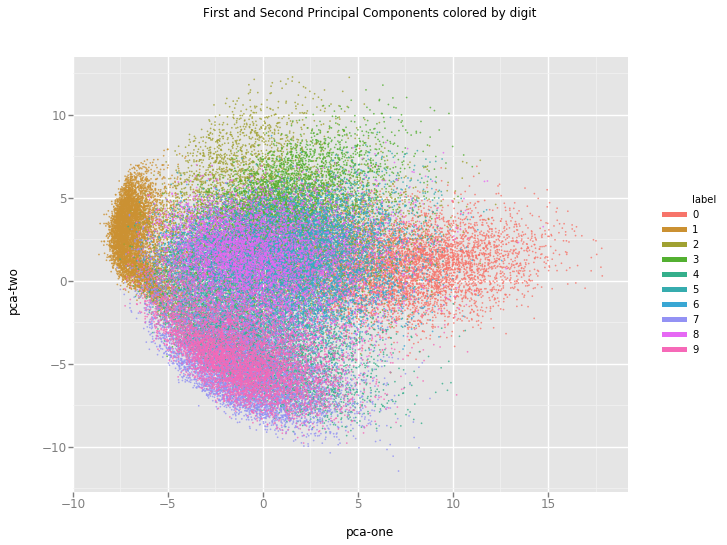

<ggplot: (-9223363276062909180)>

In [206]:
chart_1

In [228]:
tchart_1 = tsne_plot(DIDXAR, DIDYAR)

Size of the dataframe: (60000, 785)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 60000 samples in 7.051s...
[t-SNE] Computed neighbors for 60000 samples in 8444.704s...
[t-SNE] Computed conditional probabilities for sample 1000 / 60000
[t-SNE] Computed conditional probabilities for sample 2000 / 60000
[t-SNE] Computed conditional probabilities for sample 3000 / 60000
[t-SNE] Computed conditional probabilities for sample 4000 / 60000
[t-SNE] Computed conditional probabilities for sample 5000 / 60000
[t-SNE] Computed conditional probabilities for sample 6000 / 60000
[t-SNE] Computed conditional probabilities for sample 7000 / 60000
[t-SNE] Computed conditional probabilities for sample 8000 / 60000
[t-SNE] Computed conditional probabilities for sample 9000 / 60000
[t-SNE] Computed conditional probabilities for sample 10000 / 60000
[t-SNE] Computed conditional probabilities for sample 11000 / 60000
[t-SNE] Computed conditional probabilities for sample 12000 / 60000
[t-SNE] Co

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

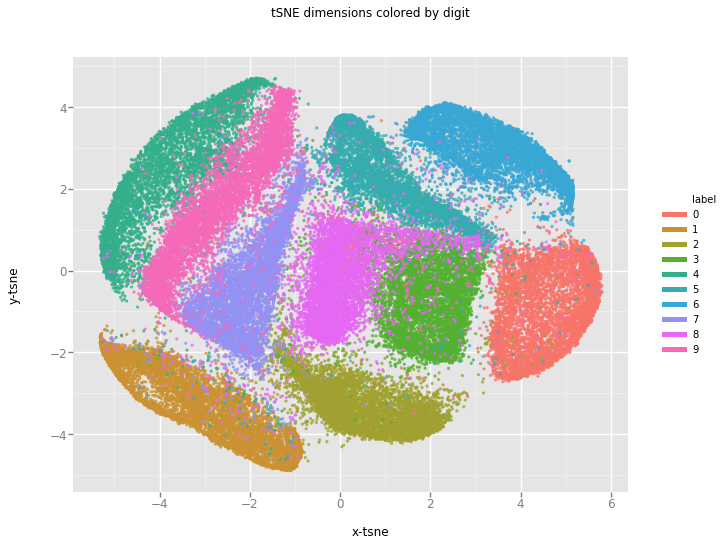

<ggplot: (-9223363276064338295)>

In [229]:
tchart_1

In [195]:
#isimetry 784-out 1 layer linear network
chart_2 = pca_plot(DIDXAR, DIDYAR)

Size of the dataframe: (60000, 785)


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

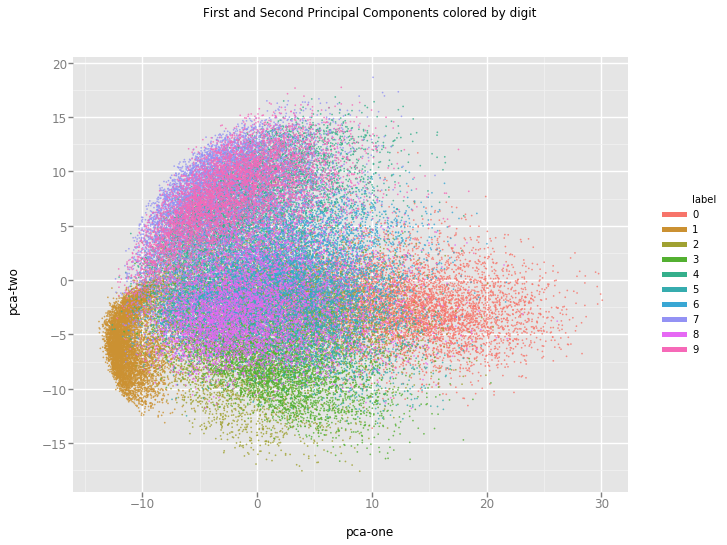

<ggplot: (8760792691709)>

In [196]:
chart_2

In [ ]:
tchart_2 = tsne_plot(DIDXAR, DIDYAR)

Size of the dataframe: (60000, 785)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 60000 samples in 5.153s...


In [ ]:
tchart_2